# State of Charge/State of Health Estimation Framework (SSEF) using Center for Advanced Life Cycle Engineering Data

# Data Peparation

## Data Overview

This dataset comes from the Center of Advanced Life Cycle Engineering (CALCE) at the University of Maryland. It is made up of four CS2 Prismatic batteries cycled continuously using Constant Current/Constant Voltage (CC/CV). The cells have a nominal capacity rating of 1100 mAh and an LiCoO2 cathode composition with traces of Mangenese. 

Each cell has features that record current, voltage, capacity, energy, resistance, and impedance sampled about every 30 seconds over the course of the full charge/discharge process. There are also features defining the current data point, time step, cycle, and CC/CV/Discharge step indication for each observation.

The CC/CV charge profile for these batteries is as follows; cells were charged with a constant current rate of 0.5A until the voltage reaches 4.2V. The voltage is then sustained at this value (4.2V) until current drops below 0.05A. Discharge cut off voltage is set to 2.7V. The CS2 cells labeled 35, 36, 37, and 38 are the only ones utilized.

[Link to Dataset](https://calce.umd.edu/battery-data#CS2, 'CALCE Data')

In [2]:
# Load all necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import warnings
# Filter unnecessary warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
# Load helper scripts
%load_ext autoreload
%autoreload 2
import helper_functions as help_func
import plotting_utilities as plot_util
import config

## Load data and remove partial charges

The first step is to load in the CS2 data from the CALCE on a battery by battery basis.

The data is stored in excel spreadsheets broken up by date.

Each date has compounding data recordings which need to be parsed separately to get a single homogeneous and consistent dataset.

Partial charges were also removed (experiments that were stopped and started in the middle of a charge/discharge).

In [3]:
# Load CALCE data and fix data recording issues
df_35_subcycle = help_func.extract_data(config.cs2_35_dates, 'data/CS2_35/CS2_35_', 'Channel_1-008')
df_35_subcycle.insert(loc=0, column='Cell_Number', value=35)

df_36_subcycle = help_func.extract_data(config.cs2_36_dates, 'data/CS2_36/CS2_36_', 'Channel_1-009')
df_36_subcycle.insert(loc=0, column='Cell_Number', value=36)

df_37_subcycle = help_func.extract_data(config.cs2_37_dates, 'data/CS2_37/CS2_37_', 'Channel_1-010')
df_37_subcycle.insert(loc=0, column='Cell_Number', value=37)

df_38_subcycle = help_func.extract_data(config.cs2_38_dates, 'data/CS2_38/CS2_38_', 'Channel_1-011')
df_38_subcycle.insert(loc=0, column='Cell_Number', value=38)

## Plot number of observations per cycle for each battery

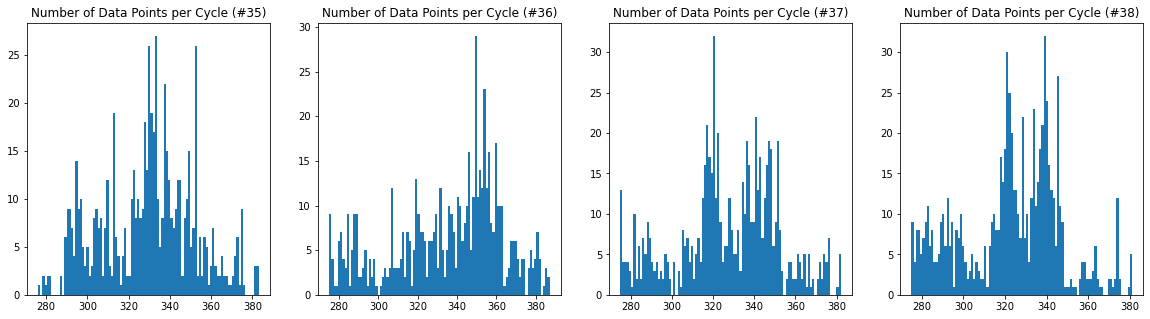

In [18]:
# Look at number of data points per cycle
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

df_35_lengths = df_35_subcycle.groupby('Cycle_Index').size().reset_index()
axs[0].hist(df_35_lengths[0], 100)
axs[0].set_title('Number of Data Points per Cycle (#35)')

df_36_lengths = df_36_subcycle.groupby('Cycle_Index').size().reset_index()
axs[1].hist(df_36_lengths[0], 100)
axs[1].set_title('Number of Data Points per Cycle (#36)')

df_37_lengths = df_37_subcycle.groupby('Cycle_Index').size().reset_index()
axs[2].hist(df_37_lengths[0], 100)
axs[2].set_title('Number of Data Points per Cycle (#37)')

df_38_lengths = df_38_subcycle.groupby('Cycle_Index').size().reset_index()
axs[3].hist(df_38_lengths[0], 100)
axs[3].set_title('Number of Data Points per Cycle (#38)')
plt.show()

## Get overall cycle information for each battery from the subcycle (charge/discharge) data

In [5]:
# Get cycling data from subcycle information
df_35 = help_func.extract_cycle_data(df_35_subcycle, 35)
df_36 = help_func.extract_cycle_data(df_36_subcycle, 36)
df_37 = help_func.extract_cycle_data(df_37_subcycle, 37)
df_38 = help_func.extract_cycle_data(df_38_subcycle, 38)

## Plot cycling data on a feature by feature basis

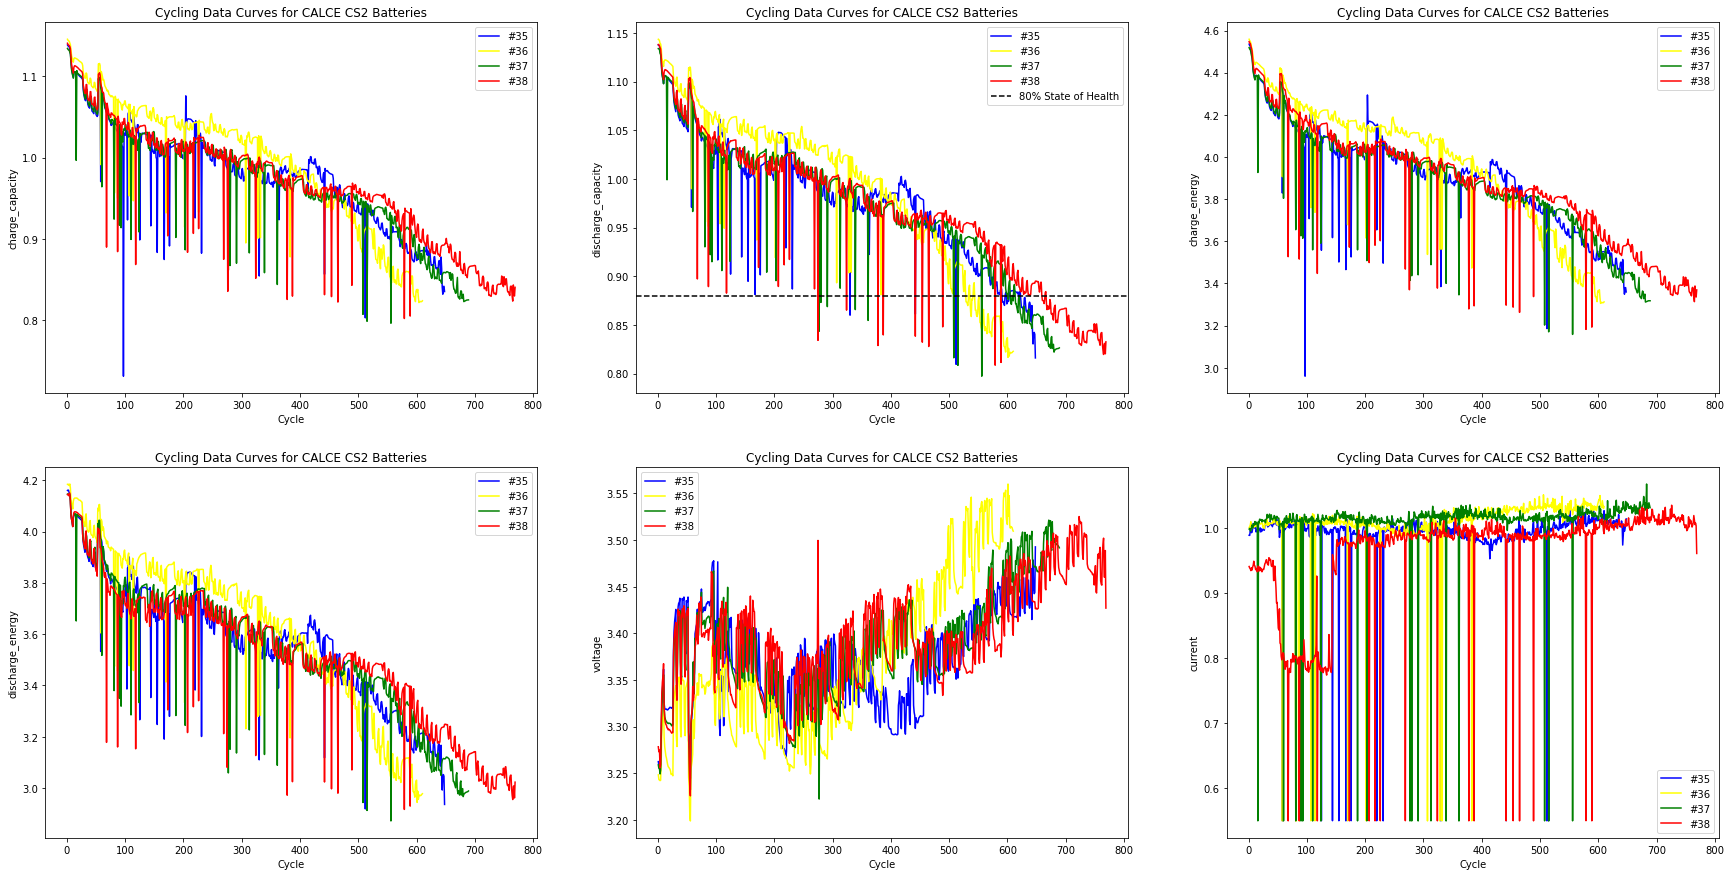

In [25]:
# Plot cycling data's available features 
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
row = 0
col = 0
for feat in config.col_for_filtering:
    axs[row, col].plot(df_35['cycle'].to_numpy(), df_35[feat].to_numpy(), color='blue', label='#35')
    axs[row, col].plot(df_36['cycle'].to_numpy(), df_36[feat].to_numpy(), color='yellow', label='#36')
    axs[row, col].plot(df_37['cycle'].to_numpy(), df_37[feat].to_numpy(), color='green', label='#37')
    axs[row, col].plot(df_38['cycle'].to_numpy(), df_38[feat].to_numpy(), color='red', label='#38')
    if feat == 'discharge_capacity':
        axs[row, col].axhline(y=config.nominal_capacity*config.eol, color='black', linestyle='--', label='80% State of Health')
    axs[row, col].legend()
    axs[row, col].set_title('Cycling Data Curves for CALCE CS2 Batteries')
    axs[row, col].set_xlabel('Cycle')
    axs[row, col].set_ylabel(feat)
    if col == 2:
        row = 1
        col = 0
    else:
        col += 1
plt.show()

## Remove outliers from cycling data

In the plots above, you can see that most experiments have unusual readings/observations for certain cycles. This is caused by unusual spikes or jumps in the voltage, current, or capacity readings during the charge/discharge process. To fix this issue, we can use the pandas rolling function to look at rolling windows of data's standard deviation for each feature and compare those standard deviation calculations to readings near each time step. We exclude cycles if the absolute difference in standard deviation is greater than q3 + iqr_cut*iqr. iqr_cut defines how strict we want to be with the exclusion, but the typical 1.5 used for normal outlier detection is sufficient for this dataset.

In [7]:
# Use time series outlier detection function to filter data
df_35_filtered = help_func.filter_outliers_local(df_35, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)
df_36_filtered = help_func.filter_outliers_local(df_36, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)
df_37_filtered = help_func.filter_outliers_local(df_37, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)
df_38_filtered = help_func.filter_outliers_local(df_38, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)

## Plot outlier filtered cycling data on a feature by feature basis

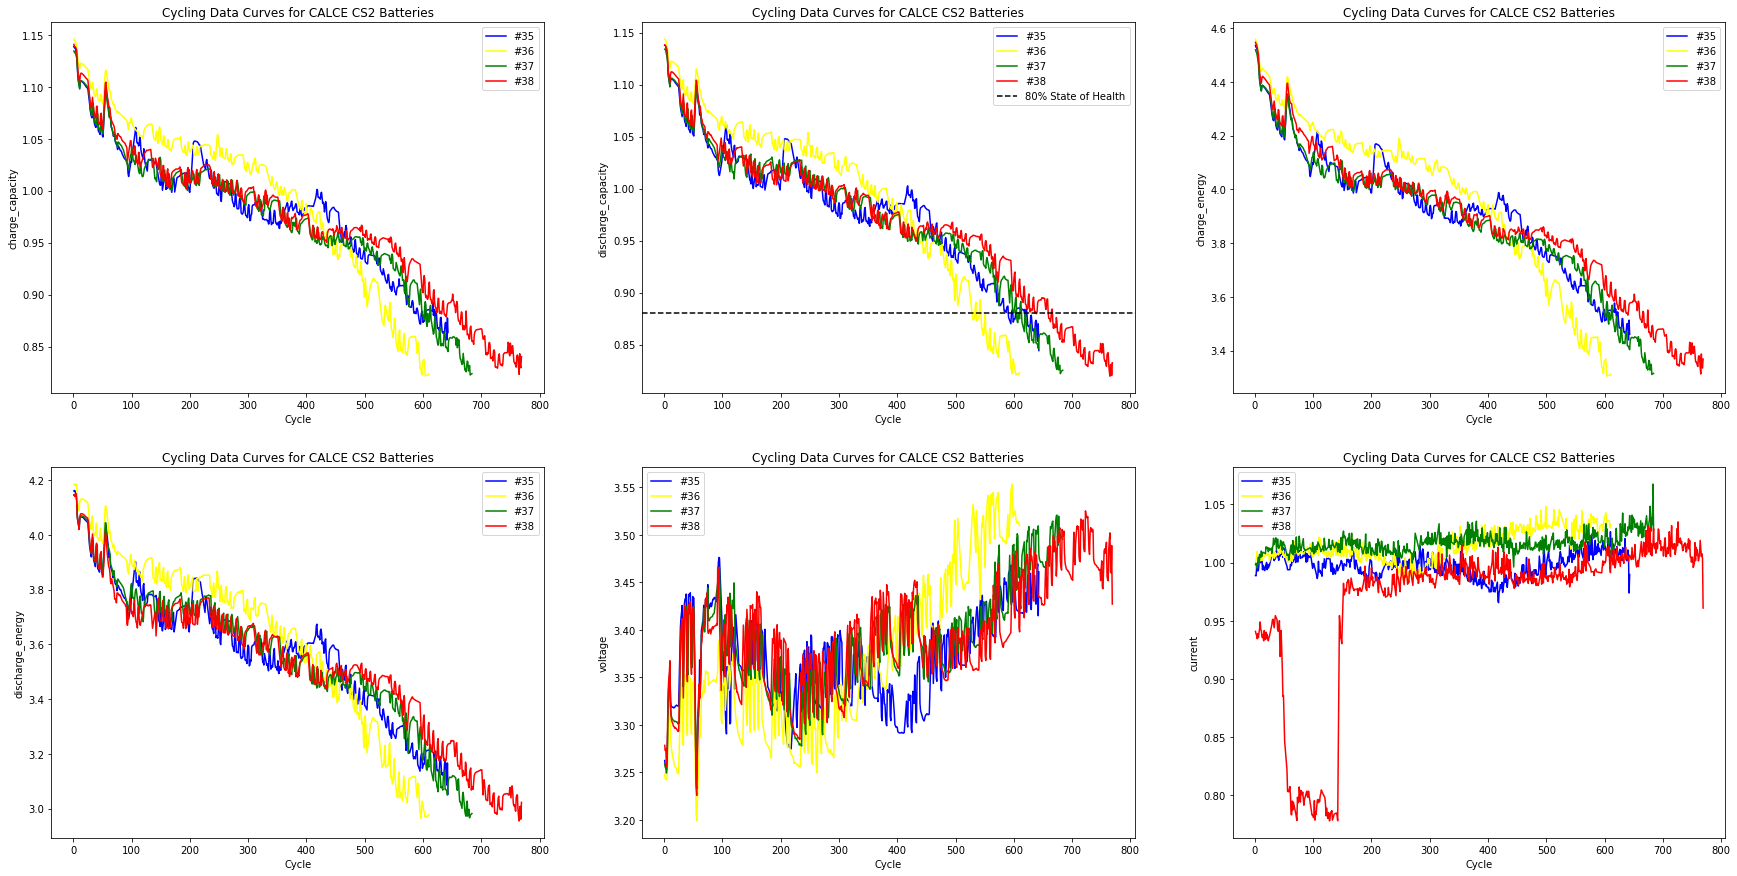

In [26]:
# Plot cycling data's available features after filtering outliers
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
row = 0
col = 0
for feat in config.col_for_filtering:
    axs[row, col].plot(df_35_filtered['cycle'].to_numpy(), df_35_filtered[feat].to_numpy(), color='blue', label='#35')
    axs[row, col].plot(df_36_filtered['cycle'].to_numpy(), df_36_filtered[feat].to_numpy(), color='yellow', label='#36')
    axs[row, col].plot(df_37_filtered['cycle'].to_numpy(), df_37_filtered[feat].to_numpy(), color='green', label='#37')
    axs[row, col].plot(df_38_filtered['cycle'].to_numpy(), df_38_filtered[feat].to_numpy(), color='red', label='#38')
    if feat == 'discharge_capacity':
        axs[row, col].axhline(y=config.nominal_capacity*config.eol, color='black', linestyle='--', label='80% State of Health')
    axs[row, col].legend()
    axs[row, col].set_title('Cycling Data Curves for CALCE CS2 Batteries')
    axs[row, col].set_xlabel('Cycle')
    axs[row, col].set_ylabel(feat)
    if col == 2:
        row = 1
        col = 0
    else:
        col += 1
plt.show()

## Chop data at 80% State of Health

Now to make data more consistent, we exclude cycles that have gone passed the defined end of life state of health (80% of the nominal capacity).

You can see around what cycle this cutoff is for each battery on the plot above (top middle).

When a battery has degredaded to end of life, maximum cell capacity readings during charge/discharge will have fallen to a predetermined reduction (80% in our case) below the nominal capacity of the cell leading to the end of the batteries lifespand and usefulness)

The nominal capacity of a battery is defined as the amount of energy possible for delivery to a brand new cell based on it's manufacure's specifications. As a cell is cycled (charged/discharged) the maximum amount of energy possible for delivery decreases due to degredation of the battery. Degredation of the battery is typically due to four main issues:
1. Lithium Plating
2. Cathode/Anode Damage
3. Passivation Layers
4. Electrolyte Oxidation 

In [9]:
# Calculate at which cycle batteries drop below 80% state of health and chop cycling and subcycle data at the 80% eol cycle
df_35_eol = help_func.create_target(df_35_filtered, config.nominal_capacity*config.eol)
df_36_eol = help_func.create_target(df_36_filtered, config.nominal_capacity*config.eol)
df_37_eol = help_func.create_target(df_37_filtered, config.nominal_capacity*config.eol)
df_38_eol = help_func.create_target(df_38_filtered, config.nominal_capacity*config.eol)

df_35_subcycle_eol = df_35_subcycle[df_35_subcycle['Cycle_Index'] <= df_35_eol['eol_cycle'].iloc[0]]
df_36_subcycle_eol = df_36_subcycle[df_36_subcycle['Cycle_Index'] <= df_36_eol['eol_cycle'].iloc[0]]
df_37_subcycle_eol = df_37_subcycle[df_37_subcycle['Cycle_Index'] <= df_37_eol['eol_cycle'].iloc[0]]
df_38_subcycle_eol = df_38_subcycle[df_38_subcycle['Cycle_Index'] <= df_38_eol['eol_cycle'].iloc[0]]

## SOC/SOH Target Creation|

We can use the capacity readings during the charge and discharge process to calculate and define state of health and state of charge at each time step and cycle.

State of Charge = current capacity / max capacity during charge/discharge

State of Health = max capacity during charge / nominal capacity

In [10]:
df_35_subcycle_soc_soh, df_35_soc_soh = help_func.calculate_soc_soh(df_35_eol, df_35_subcycle_eol, config.nominal_capacity)
df_36_subcycle_soc_soh, df_36_soc_soh = help_func.calculate_soc_soh(df_36_eol, df_36_subcycle_eol, config.nominal_capacity)
df_37_subcycle_soc_soh, df_37_soc_soh = help_func.calculate_soc_soh(df_37_eol, df_37_subcycle_eol, config.nominal_capacity)
df_38_subcycle_soc_soh, df_38_soc_soh = help_func.calculate_soc_soh(df_38_eol, df_38_subcycle_eol, config.nominal_capacity)

## Plot SOC and SOH to validate target calculation

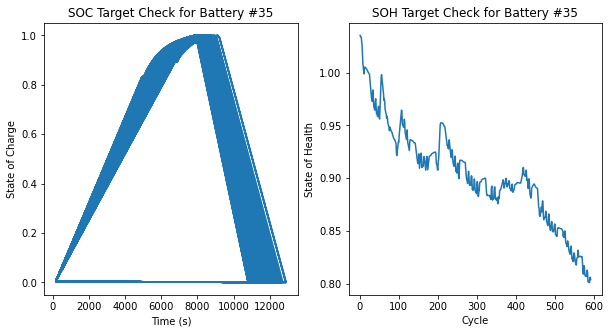

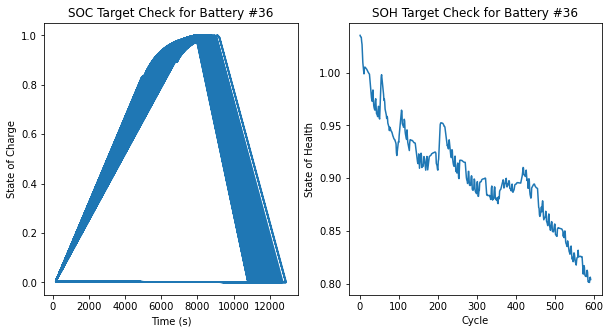

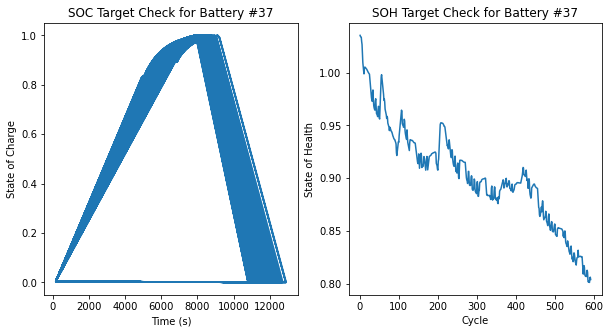

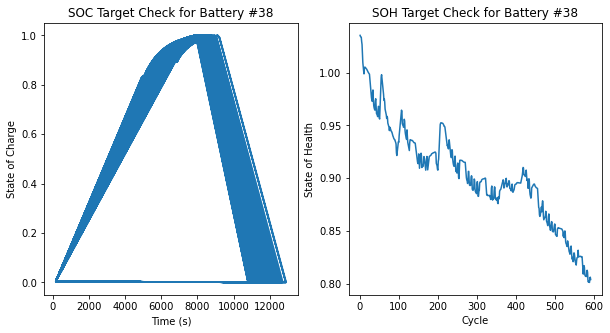

In [27]:
# Check SOC/SOH calculation
dfs = [df_35_subcycle_soc_soh, df_35_subcycle_soc_soh, df_35_subcycle_soc_soh, df_35_subcycle_soc_soh]
bats = [35, 36, 37, 38]
for data, b in zip(dfs, bats):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(data['Test_Time(s)'].to_numpy(), data['State_of_Charge'].to_numpy())
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('State of Charge')
    t = 'SOC Target Check for Battery #' + str(b)
    axs[0].set_title(t)
    axs[1].plot(data.Cycle_Index.unique(), data.State_of_Health.unique())
    axs[1].set_xlabel('Cycle')
    axs[1].set_ylabel('State of Health')
    t = 'SOH Target Check for Battery #' + str(b)
    axs[1].set_title(t)
    plt.show()



## Plot Current and Voltage readings over time for each cycle's entire charge profile

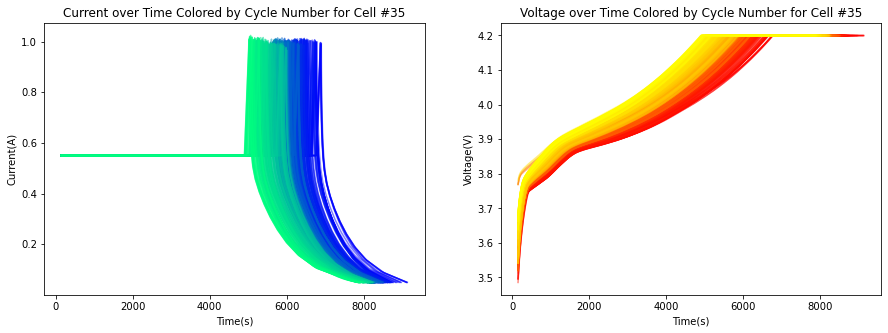

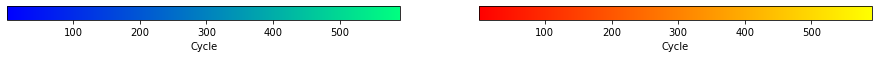

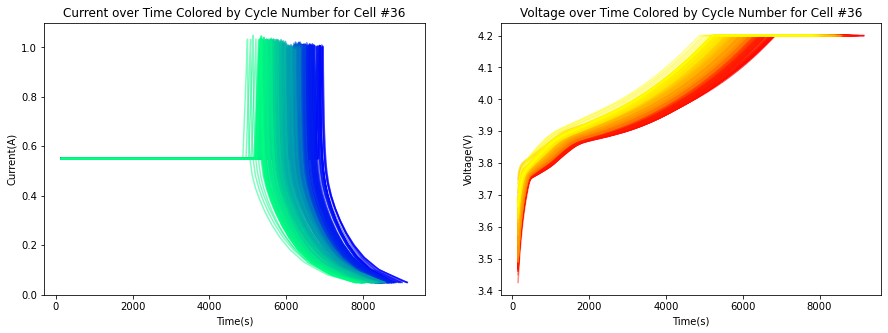

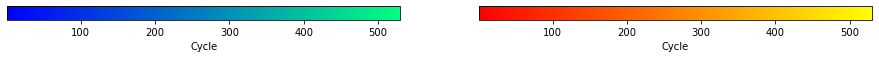

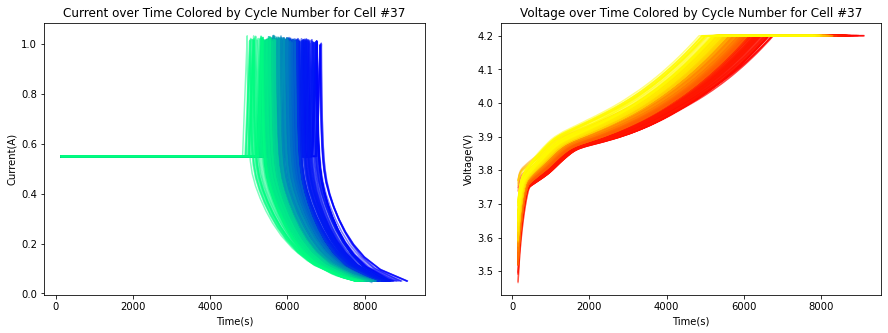

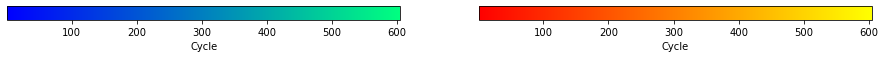

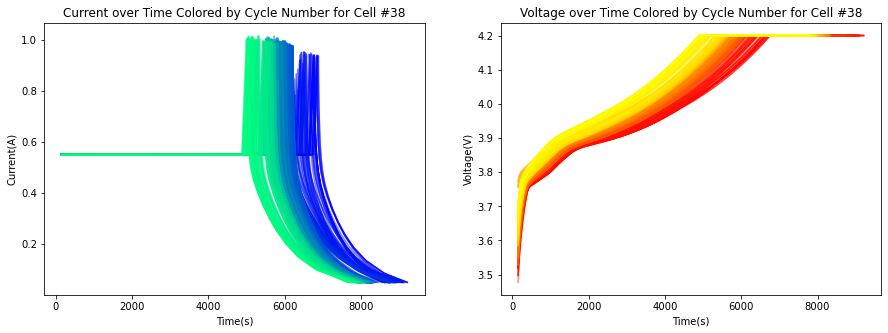

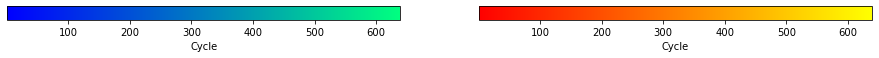

In [13]:
plot_util.plot_subcycle_data(df_35_subcycle_soc_soh, 'Current(A)', 'Voltage(V)', 35)
plot_util.plot_subcycle_data(df_36_subcycle_soc_soh, 'Current(A)', 'Voltage(V)', 36)
plot_util.plot_subcycle_data(df_37_subcycle_soc_soh, 'Current(A)', 'Voltage(V)', 37)
plot_util.plot_subcycle_data(df_38_subcycle_soc_soh, 'Current(A)', 'Voltage(V)', 38)

## Save parsed, chopped, cleaned data for faster loading

In [19]:
# Save data to avoid having to redoing parsing, chopping, target creation, and cleaning
df_35_subcycle_soc_soh.to_csv('data/calce_subcycle_data_35.csv', index=False)
df_36_subcycle_soc_soh.to_csv('data/calce_subcycle_data_36.csv', index=False)
df_37_subcycle_soc_soh.to_csv('data/calce_subcycle_data_37.csv', index=False)
df_38_subcycle_soc_soh.to_csv('data/calce_subcycle_data_38csv', index=False)
df = pd.concat([df_35_soc_soh, df_36_soc_soh, df_37_soc_soh, df_38_soc_soh])
df.to_csv('data/calce_cycling_data.csv', index=False)